# Entrenamiento de la red backpropagation

In [1]:
# Cargue de modulos
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
def depurador_df(df, mensajes = True):
  '''
  Funcion que realiza la transformacion de la base de datos al formato adecuado para entrenamiento y consumo de los modelos
  Argumentos:
    * df: dataframe con la base de datos a transformar

  Retorno:
    * Base de datos transformada en un dataframe
    * Especificaciones de la dimension de registros depurados y primeros registros si se desea
  '''

  # # # Ajuste variable floor
  df['residence_floor'] = df['Floor'].str.split(' out of ', expand=True)[0]
  df['residence_max_floor'] = df['Floor'].str.split(' out of ', expand=True)[1]

  # Con nombre de piso
  df['residence_floor'] = df['residence_floor'].apply(lambda x: re.sub(r'Ground', '1', x))         # Ground se vuelve el piso 1
  df['residence_floor'] = df['residence_floor'].apply(lambda x: re.sub(r'Lower Basement', '1', x)) # Lower Basement se vuelve el piso 1
  df['residence_floor'] = df.apply(lambda row: re.sub(r'Upper Basement', row['residence_max_floor'], row['residence_floor']) if row['residence_floor'] == 'Upper Basement' else row['residence_floor'], axis=1)
  df['residence_max_floor'] = df.apply(lambda row: row['residence_floor'] if pd.isnull(row['residence_max_floor']) else row['residence_max_floor'], axis=1)

  # Convertir a numericas
  df['residence_floor'] = df['residence_floor'].astype(int)
  df['residence_max_floor'] = df['residence_max_floor'].astype(int)

  # # Revision variable Tenant Preferred
  df["Tenant_bachelors"] = df["Tenant Preferred"].apply(lambda x: 1 if "Bachelors" in x else 0)
  df["Tenant_family"] = df["Tenant Preferred"].apply(lambda x: 1 if "Family" in x else 0)

  # # Selección de variables
  df = df[['Rent',	'BHK',	'Size',	'Area Type',	'City',	'Furnishing Status',	'Bathroom',	'Point of Contact',	'residence_floor',	'residence_max_floor',	'Tenant_bachelors',	'Tenant_family']]

  # Dicotomizando caracteristicas tipo object
  df = pd.get_dummies(df, columns=['Area Type', 'City', 'Furnishing Status', 'Point of Contact'], drop_first=True).astype(int)

  # Mensaje de transformacion exitosa
  print("SE HA DEPURADO LA BASE DE DATOS!!" + "\n")
  if mensajes:
    print(f'***Dimensiones finales {df.shape[0]} filas y {df.shape[1]} columnas *** \n')
    print(df.head(3))

  return df

In [3]:
# Cargue de datos depurados
ruta1 = input("Ingresar la ruta del archivo House_Rent_Dataset.csv (sin comillas): ").strip()

df = pd.read_csv("House_Rent_Dataset_cleaned.csv", sep = ",")
df_original = pd.read_csv(ruta1, sep = ",")

In [4]:
df.head()

,Rent,BHK,Size,Bathroom,residence_floor,residence_max_floor,Tenant_bachelors,Tenant_family,Area Type_Carpet Area,Area Type_Super Area,City_Chennai,City_Delhi,City_Hyderabad,City_Kolkata,City_Mumbai,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,Point of Contact_Contact Builder,Point of Contact_Contact Owner
0,10000,2,1100,2,1,2,1,1,0,1,0,0,0,1,0,0,1,0,1
1,20000,2,800,1,1,3,1,1,0,1,0,0,0,1,0,1,0,0,1
2,17000,2,1000,1,1,3,1,1,0,1,0,0,0,1,0,1,0,0,1
3,10000,2,800,1,1,2,1,1,0,1,0,0,0,1,0,0,1,0,1
4,7500,2,850,1,1,2,1,0,1,0,0,0,0,1,0,0,1,0,1


In [5]:
# # Division de la base en entrenamiento y test
x = df.drop('Rent', axis=1)
y = df['Rent']

In [6]:
# Estandarizacion
scaler = StandardScaler()
x = scaler.fit_transform(x)

# # Entrenamiento vs test vs validacion
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# # Validacion intra modelo
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

# Dimensiones
print("x_train: ",  x_train.shape)
print("x_test: ", x_test.shape)
print("x_val: ", x_val.shape)

x_train:  (3416, 18)
x_test:  (950, 18)
x_val:  (380, 18)


In [7]:
# Definicion de la Arquitectura
model = keras.Sequential([
    layers.Dense(128, activation='relu', kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001), input_shape=(x_train.shape[1],)),
    layers.Dense(64, activation='relu', kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001)),
    layers.Dense(32, activation='relu', kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='linear')
])

# Compilar el modelo
model.compile(optimizer='adam',  # RMSprop, adam
              loss='mean_squared_error',
              metrics=['mape'])

# Entrenando el modelo
history = model.fit(x_train, y_train,
                    epochs = 50,
                    batch_size = 16,
                    verbose = 0,
                    validation_data = (x_val, y_val)
)


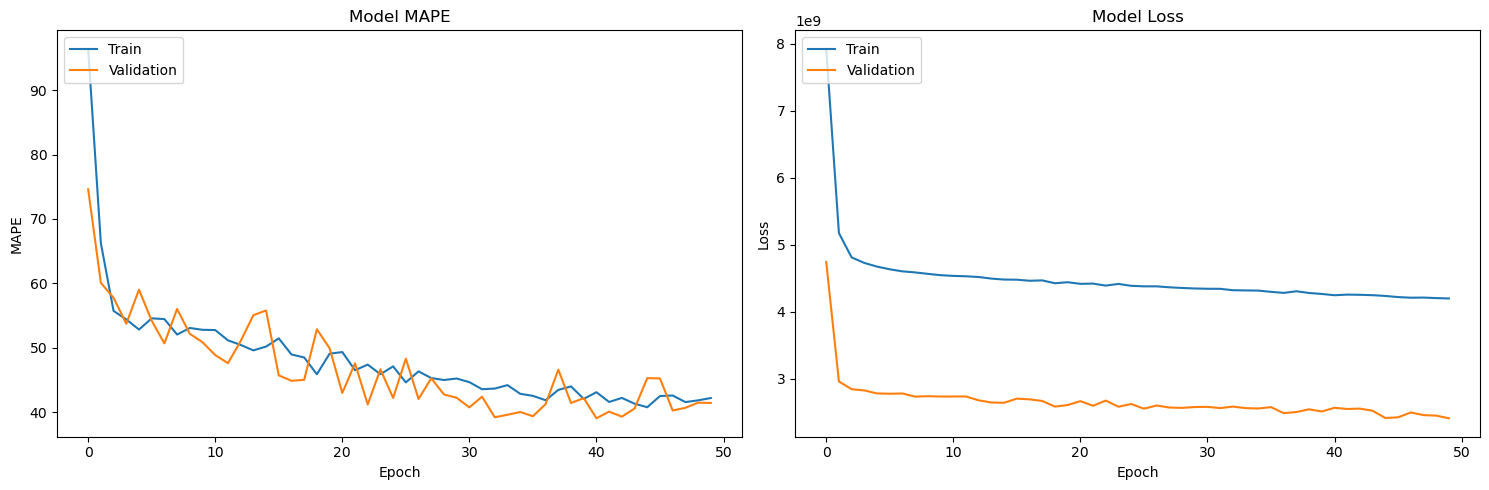

In [8]:
#Create a grid of plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#Plot MAPE on the first subplot
axes[0].plot(history.history['mape'])
axes[0].plot(history.history['val_mape'])
axes[0].set_title('Model MAPE')
axes[0].set_ylabel('MAPE')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

#Plot Loss on the second subplot
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  # Adjusts subplot parameters for a tight layout
plt.show()


## Evaluacion en datos de entrenamiento ; metricas de desempeño

In [9]:
def evaluar_modelo(model, x_test, y_test):
    y_pred = model.predict(x_test)
    # Calcular métricas de evaluación
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Guardar resultados en df
    results = pd.DataFrame({
        'MSE': [mse],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape],
        'R2': [r2]
    })

    return results

In [10]:
evaluar_modelo(model, x_test, y_test)

30/30 [==============================] - 0s 778us/step


,MSE,RMSE,MAE,MAPE,R2
0,1.213371e+09,34833.470285,13301.715795,0.44051,0.695545
